What we're going to do is take a complete dataset and then see how fair imputation differs when data is missing for systemic reasons vs non systemic reasons

Outline:

- Take a dataset and then calculate fairness. This will be the baseline dataset.
- Then create two seperate datasets with synthetically missing data. One dataset will be missing data entirely at random. The other dataset will be missing data that is missing data systematically. So the data that is missing will be biased. For example: If salary data is used then women are less likely to have filled in data about their salary.


For this we will be using the [Salary_Data](https://www.kaggle.com/datasets/mohithsairamreddy/salary-data) dataset from Kaggle.com

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('Salary_Data.csv')
df.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0


In [3]:
df.count()

Age                    6702
Gender                 6702
Education Level        6701
Job Title              6702
Years of Experience    6701
Salary                 6699
dtype: int64

In [4]:
df[df.isnull().any(axis=1)]

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
172,NaN,NaN,NaN,NaN,NaN,NaN
260,NaN,NaN,NaN,NaN,NaN,NaN
2011,27.0,Male,NaN,Developer,7.0,100000.0
3136,31.0,Male,Master's Degree,Full Stack Engineer,8.0,NaN
5247,26.0,Female,Bachelor's Degree,Social M,NaN,NaN
6455,36.0,Male,Bachelor's Degree,Sales Director,6.0,NaN


There are 2 values that are completely missing data. These can be disposed of easily and then 4 pieces of data that are missing data partially. This amounts to a small amount of data so will be deleted. Although the irony of doing this given the nature of my research is not lost on me.

In [5]:
df.dropna(inplace=True)


In [6]:
df.count()

Age                    6698
Gender                 6698
Education Level        6698
Job Title              6698
Years of Experience    6698
Salary                 6698
dtype: int64

In [7]:
df[df.isnull().any(axis=1)]

,Age,Gender,Education Level,Job Title,Years of Experience,Salary


In [8]:
df.dtypes

Age                    float64
Gender                  object
Education Level         object
Job Title               object
Years of Experience    float64
Salary                 float64
dtype: object

In [9]:
df['Gender'].unique()

array(['Male', 'Female', 'Other'], dtype=object)

In [10]:
df['Gender'].replace({'Male': 0, 'Female': 1, 'Other': 2}, inplace=True)
df['Gender'].unique()

/var/folders/6w/80_zjn_967155t1gs52zd8jc0000gn/T/ipykernel_17885/753572149.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Gender'].replace({'Male': 0, 'Female': 1, 'Other': 2}, inplace=True)
/var/folders/6w/80_zjn_967155t1gs52zd8jc0000gn/T/ipykernel_17885/753572149.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_sil

array([0, 1, 2])

In [11]:
df['Education Level'].unique()

array(["Bachelor's", "Master's", 'PhD', "Bachelor's Degree",
       "Master's Degree", 'High School', 'phD'], dtype=object)

In [12]:
df['Education Level'].replace({"Bachelor's": 1, "Master's": 2, 'PhD': 3, "Bachelor's Degree": 1,
       "Master's Degree": 2, 'High School': 0, 'phD': 3}, inplace=True)
df['Education Level'].unique()

/var/folders/6w/80_zjn_967155t1gs52zd8jc0000gn/T/ipykernel_17885/3528430564.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Education Level'].replace({"Bachelor's": 1, "Master's": 2, 'PhD': 3, "Bachelor's Degree": 1,
/var/folders/6w/80_zjn_967155t1gs52zd8jc0000gn/T/ipykernel_17885/3528430564.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd

array([1, 2, 3, 0])

Converting job titles into a numeric value is a bit more involved as individuals can list a wide variety of job titles. Yet, performing evaluations easily requires numeric values. To solve this I train a model to vectorise all the words then use KMeans and PCA group job titles into similar groups.

In [13]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.utils import simple_preprocess

data = df.copy()

job_titles = data['Job Title'].tolist()
tokenized_job_titles = [simple_preprocess(title) for title in job_titles]
dictionary = Dictionary(tokenized_job_titles)


bow_corpus = [dictionary.doc2bow(doc) for doc in tokenized_job_titles]
tfidf = TfidfModel(bow_corpus)
tfidf_corpus = tfidf[bow_corpus]


In [14]:
from pprint import pprint as print
from gensim.models.fasttext import FastText
from gensim.test.utils import datapath


corpus_file = datapath('lee_background.cor')

model = FastText(vector_size=100)
model.build_vocab(corpus_file=corpus_file)

model.train(
    corpus_file=corpus_file, epochs=model.epochs,
    total_examples=model.corpus_count, total_words=model.corpus_total_words,
)

print(model)

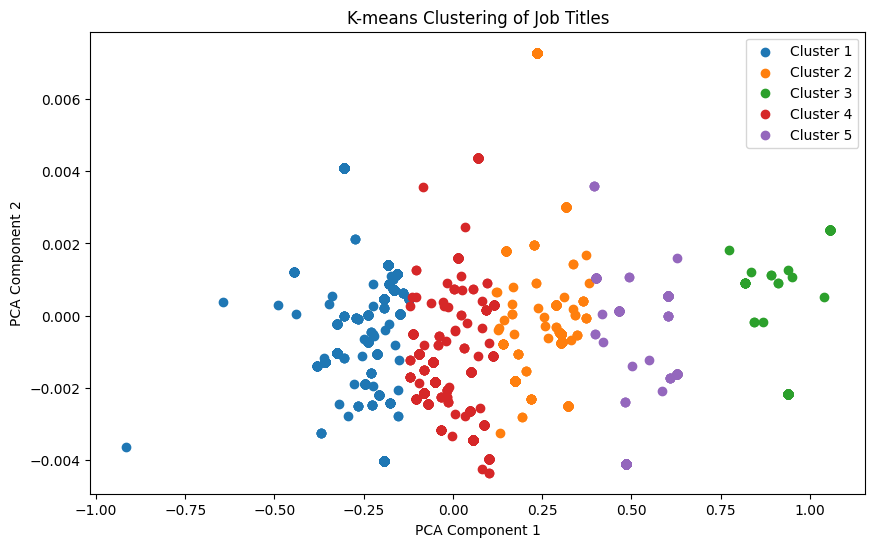

In [15]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

job_titles = data['Job Title'].tolist()
job_title_embeddings = [model.wv[title] for title in job_titles]

kmeans = KMeans(n_clusters=5)  
kmeans.fit(job_title_embeddings)
cluster_labels = kmeans.labels_

pca = PCA(n_components=2)  
job_title_embeddings_2d = pca.fit_transform(job_title_embeddings)

plt.figure(figsize=(10, 6))
for cluster_label in range(kmeans.n_clusters):
    plt.scatter(job_title_embeddings_2d[cluster_labels == cluster_label, 0],
                job_title_embeddings_2d[cluster_labels == cluster_label, 1],
                label=f'Cluster {cluster_label + 1}')
plt.title('K-means Clustering of Job Titles')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()


In [16]:
from sklearn.cluster import KMeans
import numpy as np

job_title_embeddings = [model.wv[title] for title in data['Job Title']]
job_title_embeddings_array = np.array(job_title_embeddings)

kmeans = KMeans(n_clusters=5)  
kmeans.fit(job_title_embeddings_array)

data['Job Title'] = kmeans.labels_

data.head()


    Age  Gender  Education Level  Job Title  Years of Experience    Salary
0  32.0       0                1          0                  5.0   90000.0
1  28.0       1                2          0                  3.0   65000.0
2  45.0       0                3          1                 15.0  150000.0
3  36.0       1                1          0                  7.0   60000.0
4  52.0       0                2          2                 20.0  200000.0


In [18]:
data['Job Title'] = data['Job Title'].astype('int64')

In [19]:
df = data.copy()

In [20]:
df.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,0,1,0,5.0,90000.0
1,28.0,1,2,0,3.0,65000.0
2,45.0,0,3,1,15.0,150000.0
3,36.0,1,1,0,7.0,60000.0
4,52.0,0,2,2,20.0,200000.0


# Baseline model

With the baseline model we will train a model to predict the salary of a person.
Then calculate fairness metrics using this model. We will use this as a control model to compare the impact of fairness when imputation is used on data that is missing completely at random or data that is missing for systematic reasons.

The fairness metrics that will be assessed are:
- Demographic/ Statistical Parity
- Conditional Demographic Parity (used to avoid Simpson's paradox)
- Disparate Impact

These metrics were chosen for the slightly varied ways that they assess fairness.

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [49]:
X = data[['Age', 'Gender', 'Education Level', 'Job Title', 'Years of Experience']]
y = data['Salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42) 
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

'Mean Squared Error: 175262090.08961433'


               Feature  Importance
4  Years of Experience    0.777049
0                  Age    0.082802
3            Job Title    0.070314
2      Education Level    0.054272
1               Gender    0.015563


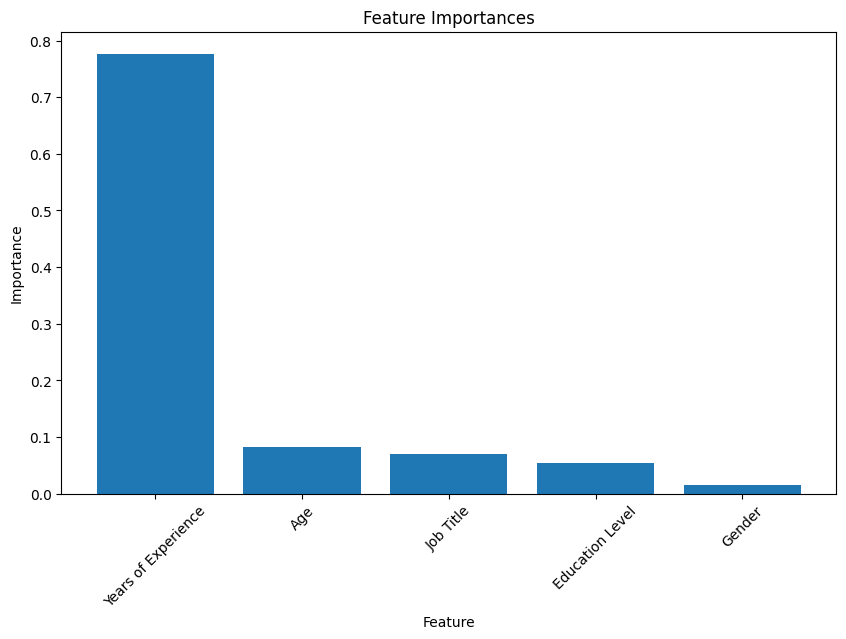

In [23]:
# Get feature importances
feature_importances = model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': ['Age', 'Gender', 'Education Level', 'Job Title', 'Years of Experience'],
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.xticks(rotation=45)
plt.show()

### Baseline model evaluation

Now that the model is trained we will evaluate it on certain fairness metrics.
[Fairness metric calculations](https://transformernlp.medium.com/ai-fairness-a-brief-introduction-to-ai-fairness-360-b2e39c96ca49)

Stastiical Parity Difference is the difference in the rate of favourable outcomes received by unprivileged groups to the privileged group. Ideally this value will be 0 which signifies no bias. Negative values represent a bias towards the privileged group and positive values represent a bias towards the unprivileged group.

In [24]:
def statistical_parity_difference(df, protected_characteristic, target, privileged_group, unprivileged_group, favourable_threshold):
    """
    Calculates the statistical parity difference.
    :param df: the dataframe that you are using, needs to be a pandas df
    :protected_characteristic: the characteristic we are differentiating between (i.e. Gender)
    :target: the target variable (i.e. salary)
    :param privileged_group: the group that is privileged
    :param unprivileged_group: group that is unprivileged
    :param favourable_threshold: amount that labels someone as being treated favourably (we are dealing with salary so that is why we are talking about treating someone favourably)

    Statistical parity is calculated using the formula: (number of favorable instances for unprivileged group/total number of instances of unprivileged group) - (number of favorable instances for privileged group/total number of instances of privileged group)
    """

    number_of_favourable_instances_for_unprivileged_group = df.query(f'{target} >= {favourable_threshold} & {protected_characteristic} == {unprivileged_group}').shape[0]
    total_number_of_instances_of_unprivileged_group = df.query(f'{protected_characteristic} == {unprivileged_group}').shape[0]

    number_of_favourable_instances_for_privileged_group = df.query(f'{target} >= {favourable_threshold} & {protected_characteristic} == {privileged_group}').shape[0]
    total_number_of_instances_of_privileged_group = df.query(f'{protected_characteristic} == {privileged_group}').shape[0]

    return (number_of_favourable_instances_for_unprivileged_group/total_number_of_instances_of_unprivileged_group) - (number_of_favourable_instances_for_privileged_group /total_number_of_instances_of_privileged_group)


In [25]:
print((df['Salary'] >= 150000).sum()) # we consider those that earn over £150,000 to be treated favourably
statistical_parity_difference(df, 'Gender', 'Salary', 0, 1, 150000)

2136


-0.08717368656642066

Disparate impact is the rate of favourable outcome for the unprivileged group to the privileged group. The ideal value is 1.

In [26]:
def disparate_impact(df, protected_characteristic, target, privileged_group, unprivileged_group, favourable_threshold):
    """
    Calculates the disparate impact.
    :param df: the dataframe that you are using, needs to be a pandas df
    :protected_characteristic: the characteristic we are differentiating between (i.e. Gender)
    :target: the target variable (i.e. salary)
    :param privileged_group: the group that is privileged
    :param unprivileged_group: group that is unprivileged
    :param favourable_threshold: amount that labels someone as being treated favourably (we are dealing with salary so that is why we are talking about treating someone favourably)

    Disparate impact is calculated using the formula: (number of favorable instances for unprivileged group/total number of instances of unprivileged group) / (number of favorable instances for privileged group/total number of instances of privileged group)
    """
    number_of_favourable_instances_for_unprivileged_group = df.query(f'{target} >= {favourable_threshold} & {protected_characteristic} == {unprivileged_group}').shape[0]
    total_number_of_instances_of_unprivileged_group = df.query(f'{protected_characteristic} == {unprivileged_group}').shape[0]

    number_of_favourable_instances_for_privileged_group = df.query(f'{target} >= {favourable_threshold} & {protected_characteristic} == {privileged_group}').shape[0]
    total_number_of_instances_of_privileged_group = df.query(f'{protected_characteristic} == {privileged_group}').shape[0]

    return (number_of_favourable_instances_for_unprivileged_group/total_number_of_instances_of_unprivileged_group) / (number_of_favourable_instances_for_privileged_group /total_number_of_instances_of_privileged_group)

    

In [27]:
disparate_impact(df, 'Gender', 'Salary', 0, 1, 150000)

0.7562721984879435

To avoid falling into Simpson's paradox, conditional demographic disparity is also used as a metric.
As detailed [here](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-data-bias-metric-cddl.html), 

The range of values reveal that:

+1: when there no rejections in facet a or subgroup and no acceptances in facet d or subgroup

Positive values indicate there is a demographic disparity as facet d or subgroup has a greater proportion of the rejected outcomes in the dataset than of the accepted outcomes. The higher the value the less favored the facet and the greater the disparity.

Negative values indicate there is not a demographic disparity as facet d or subgroup has a larger proportion of the accepted outcomes in the dataset than of the rejected outcomes. The lower the value the more favored the facet.

-1: when there are no rejections in facet d or subgroup and no acceptances in facet a or subgroup

We will use education level as a way to create conditionals.

In [28]:
def conditional_demographic_disparity(df, protected_characteristic, target, privileged_group, unprivileged_group, favourable_threshold, conditonals:list):
    """
    Calculates the conditional demographic disparity.
    :param df: the dataframe that you are using, needs to be a pandas df
    :param protected_characteristic: the characteristic we are differentiating between (i.e. Gender)
    :param target: the target variable (i.e. salary)
    :param privileged_group: the group that is privileged
    :param unprivileged_group: group that is unprivileged
    :param favourable_threshold: amount that labels someone as being treated favourably (we are dealing with salary so that is why we are talking about treating someone favourably)
    :param conditionals: variables to be conditionalised on (e.g. education or job type)
    :return: conditional demographic disparity
    """
    total_number_of_observations = df.shape[0]
    sub_group_count = 0
    for i in conditonals:
        for j in df[f'{i}'].unique():
            curr_df = df.loc[(df[f'{i}']) == j]
            sub_group_count += statistical_parity_difference(curr_df, protected_characteristic, target, privileged_group, unprivileged_group, favourable_threshold) * curr_df.shape[0]
    
    return (1/total_number_of_observations) * sub_group_count



    

In [29]:
conditional_demographic_disparity(df, 'Gender', 'Salary', 0, 1, 150000, ['Job Title', 'Education Level'])

-0.15620593255267728

# Assessing the datasets with missing data

Two more datasets will be created. One will be missing data entirely at random. That means at random, data points will be taken out and replaced with a NaN value.
The other dataset will be missing data for more systematic reasons. So 15% of salary data will be missing from women and 5% of data missing will be from men. 

The missing data will be imputed using a (fair) imputer and then assessed in order to compare results across the board.

Note that in both cases we only ever impute on the salary column. This is to create as controlled an environment as possible.

## Data missing completely at random

In [30]:
completely_missing_df = df.copy()

In [31]:
completely_missing_df.shape[0] * 0.2

1339.6000000000001

In [32]:
num_nan_values = 1340 # represents 20% of total values. Because we want to remain consistent.
indices_to_replace = np.random.choice(completely_missing_df.index, num_nan_values, replace=False)
completely_missing_df.loc[indices_to_replace, 'Salary'] = np.nan

In [33]:
completely_missing_df.count()

Age                    6698
Gender                 6698
Education Level        6698
Job Title              6698
Years of Experience    6698
Salary                 5358
dtype: int64

In [34]:
print(f"Number of missing values for men: {completely_missing_df[completely_missing_df['Gender'] == 0]['Salary'].isnull().sum()}")
print(f"Number of missing values for women: {completely_missing_df[completely_missing_df['Gender'] == 1]['Salary'].isnull().sum()}")

'Number of missing values for men: 720'
'Number of missing values for women: 619'


### Imputation of completely missing at random dataset

In [35]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
# TODO: try and implement fair imputer instead of using iterative imputation

imp = IterativeImputer(max_iter=10, random_state=0)
imputed_df = pd.DataFrame(imp.fit_transform(completely_missing_df))
imputed_df.columns = completely_missing_df.columns
imputed_df.index = completely_missing_df.index
imputed_df.head()



,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,0.0,1.0,0.0,5.0,90000.00000
1,28.0,1.0,2.0,0.0,3.0,65000.00000
2,45.0,0.0,3.0,1.0,15.0,150000.00000
3,36.0,1.0,1.0,0.0,7.0,60000.00000
4,52.0,0.0,2.0,2.0,20.0,179104.05833


In [36]:
imputed_df.count()

Age                    6698
Gender                 6698
Education Level        6698
Job Title              6698
Years of Experience    6698
Salary                 6698
dtype: int64

In [37]:
# conversion takes place just to keep naming of variables easy to track
# needed to temporarily use imputed_df just to ensure that columns and index were properly kept track of
completely_missing_df = imputed_df.copy()

### Evaluating fairness using same fairness metrics as before

In [38]:
print(f"Demographic parity for the dataset where data is missing entirely at random is: {statistical_parity_difference(completely_missing_df, 'Gender', 'Salary', 0, 1, 150000)}")
print(f"Disparate impact for the dataset where data is missing entirely at random is: {disparate_impact(completely_missing_df, 'Gender', 'Salary', 0, 1, 150000)}")
print(f"Conditional demographic disparity for the dataset where data is missing entirely at random is: {conditional_demographic_disparity(completely_missing_df, 'Gender', 'Salary', 0, 1, 150000, ['Job Title', 'Education Level'])}")

('Demographic parity for the dataset where data is missing entirely at random '
 'is: -0.10415666317653921')
('Disparate impact for the dataset where data is missing entirely at random '
 'is: 0.6996393475875291')
('Conditional demographic disparity for the dataset where data is missing '
 'entirely at random is: -0.18826828913161378')


### Imputation of dataset that is missing systematically

In [39]:
missing_system_df = df.copy()


In [40]:
num_nan_values = round(missing_system_df.shape[0] * 0.15)
indices_to_replace = missing_system_df[missing_system_df['Gender'] == 1].index
indices_to_replace_subset = np.random.choice(indices_to_replace, num_nan_values, replace=False)
missing_system_df.loc[indices_to_replace_subset, 'Salary'] = np.nan



In [41]:
missing_system_df.count()

Age                    6698
Gender                 6698
Education Level        6698
Job Title              6698
Years of Experience    6698
Salary                 5693
dtype: int64

In [42]:
num_nan_values = round(missing_system_df.shape[0] * 0.05)
indices_to_replace = missing_system_df[missing_system_df['Gender'] == 0].index
indices_to_replace_subset = np.random.choice(indices_to_replace, num_nan_values, replace=False)
missing_system_df.loc[indices_to_replace_subset, 'Salary'] = np.nan

In [43]:
missing_system_df.count()

Age                    6698
Gender                 6698
Education Level        6698
Job Title              6698
Years of Experience    6698
Salary                 5358
dtype: int64

In [44]:
print(f"Number of missing values for men: {missing_system_df[missing_system_df['Gender'] == 0]['Salary'].isnull().sum()}")
print(f"Number of missing values for women: {missing_system_df[missing_system_df['Gender'] == 1]['Salary'].isnull().sum()}")

'Number of missing values for men: 335'
'Number of missing values for women: 1005'


In [45]:
imp = IterativeImputer(max_iter=10, random_state=0)
imputed_df = pd.DataFrame(imp.fit_transform(missing_system_df))
imputed_df.columns = missing_system_df.columns
imputed_df.index = missing_system_df.index
imputed_df.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,0.0,1.0,0.0,5.0,90000.000000
1,28.0,1.0,2.0,0.0,3.0,65000.000000
2,45.0,0.0,3.0,1.0,15.0,150000.000000
3,36.0,1.0,1.0,0.0,7.0,93348.658783
4,52.0,0.0,2.0,2.0,20.0,200000.000000


In [46]:
imputed_df.count()

Age                    6698
Gender                 6698
Education Level        6698
Job Title              6698
Years of Experience    6698
Salary                 6698
dtype: int64

In [47]:
# conversion takes place just to keep naming of variables easy to track
# needed to temporarily use imputed_df just to ensure that columns and index were properly kept track of
missing_system_df = imputed_df.copy()

### Evaluating fairness with dataset that is missing systematically

In [48]:
print(f"Demographic parity for the dataset where data is missing systematically is: {statistical_parity_difference(missing_system_df, 'Gender', 'Salary', 0, 1, 150000)}")
print(f"Disparate impact for the dataset where data is missing systematically is: {disparate_impact(missing_system_df, 'Gender', 'Salary', 0, 1, 150000)}")
print(f"Conditional demographic disparity for the dataset where data is missing systematically is: {conditional_demographic_disparity(missing_system_df, 'Gender', 'Salary', 0, 1, 150000, ['Job Title', 'Education Level'])}")

('Demographic parity for the dataset where data is missing systematically is: '
 '-0.12508486108909878')
('Disparate impact for the dataset where data is missing systematically is: '
 '0.6454158107659601')
('Conditional demographic disparity for the dataset where data is missing '
 'systematically is: -0.22910659990197255')


# Results

One set of results that were obtained are as follows (note that due to the randomness involved with imputation, results can differ):
#### Baseline results:
- Demographic/ statistical parity: -0.08717368656642066
- Disparate impact: 0.7562721984879435
- Conditional demographic disparity: -0.15839796446659044

#### Data completely missing at randoom:
- Demographic parit/ statistical: -0.06926364578518063
- Disparate impact: 0.7566824462417243
- Conditional demographic disparity: -0.12449082811419396

#### Data missing systematically:
- Demographic/ statistical parity: -0.11594522347228114
- Disparate impact: 0.6720840405495038
- Conditional demographic disparity: -0.21333260553428218

As we can see Data that is missing systematically experiences radical divergences from the baseline results whereas data that is missing completely at random does not experience such big changes. 

These results can be used to demonstrate that imputation has much more negative effects on fairness when data is missing systematically. 